# Experiments : Synthetic data, Popularity model

In this notebook, we run experiments by creating a synthetic delegation network using the popularity model. In this model, users delegate in priority to people who are very popular (i.e. they have a lot of followers).

In [1]:
import rankedDelegation as rd
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.utils import io
np.random.seed(42)

## Saving the results
We will use the following function to save the election, and the election results

In [7]:
def save_election(e, results, title=""):
    L = []
    C = []
    timestamp = int(time.time())
    for v in tqdm(e.list_voters):
        for i, d in enumerate(v.delegatees):
            L.append((v.id, d.id, i+1))
        if v.vote is not None:
            C.append((v.id, 1))
        else:
            C.append((v.id, 0))
        
    np.savetxt("Save/Synthetic/edges_%s_%i.csv"%(title,timestamp), L)
    np.savetxt("Save/Synthetic/nodes_%s_%i.csv"%(title,timestamp), C)
    results.to_csv("Save/Synthetic/results_%s_%i.csv"%(title, timestamp))

## Running the experiments

We will run the experiments on wide ruleset, testing all the rules described on the paper (BFD, DFD, MinSum, Diffusion, LexiMax and BordaArborescence). We will look at a wide set of metrics:

* Maximum rank in a delegation path
* Maximum length of a delegation path
* Average length of the delegation paths
* Maximum Power/Representation of a casting voter
* Power entropy
* Maximum sum of rank of a delegation path
* Sum of all rank in the arborescence (for confluent rules)
* Average rank in the arborescence (for confluent rules)
* Unpopularity of the arborescence (for confluent rules)


In [16]:
rules = [rd.rules.breadthFirst, rd.rules.minSum, rd.rules.depthFirst, 
             rd.rules.diffusion, rd.rules.lexiMax, rd.rules.bordaArb]
rules_str = ["BFD", "MinSum", "DFD","Diffusion", "LexiMax","BordaArb"]
metrics_str = ["Max Rank", "Max Length", "Avg Length","Max Power", "Max representation",
                "Power entropy", "Max Sum", "Sum of Rank", "Avg Rank", "Unpopularity"]
n_rules = len(rules)

The following function run elections on networks and compute the results (using the metrics define above)

In [6]:
def run_election():
    
    tab_results = np.zeros((9, n_rules))
    n_iter = 50
    n_voter = 1000
    n_rules = len(rules)

    for _ in tqdm(range(n_iter)):
        with io.capture_output() as captured:
            e = create_election_popularity(n_voter)
            tab_results = np.zeros((10, n_rules))
            for i, rule in enumerate(rules):
                e.attribute_gurus(rule)
                tab_results[0, i] += e.max_rank
                tab_results[1, i] += e.max_length
                tab_results[2, i] += e.mean_length
                tab_results[3, i] += e.max_power
                tab_results[4, i] += e.max_representation
                tab_results[5, i] += e.power_entropy
                tab_results[6, i] += e.max_sum
                tab_results[7, i] += e.sum_rank
                tab_results[8, i] += e.avg_rank
                tab_results[9, i] += e.unpopularity
            df = pd.DataFrame(tab_results.T, index=rules_str, columns=metrics_str)
            save_election(e, df, "pop1000")


The following function simply create elections for different casting probability.

In [1]:
def create_elections(list_p = [0.5,0.8,0.9,0.95,0.98,0.99]):
    
    tab_results = np.zeros((9, n_rules))
    n_iter = 50
    n_voter = 1000
    n_rules = len(rules)
    
    for proba_p in list_p:
        for _ in tqdm(range(n_iter)):
            with io.capture_output() as captured:
                e = create_election_popularity(n_voter, p=proba_p)
                tab_results = np.zeros((10, n_rules))
                df = pd.DataFrame(tab_results.T, index=rules_str, columns=metrics_str)
                save_election(e, df, "pop1000-%.2f"%(proba_p))


## Changing parameters

We also looked at what happens if we change the values of the different parameters

In [2]:
def experiment(n_iter=100, n=1000,p=0.8,n_delegatees=4,popularity=1):
    tab_results = np.zeros((10, n_rules))
    for _ in range(n_iter):
        e = create_election_popularity(n, p, n_delegatees,popularity)

        for i, rule in enumerate(rules):
            e.attribute_gurus(rule)
            
            tab_results[0, i] += e.max_rank
            tab_results[1, i] += e.max_length
            tab_results[2, i] += e.mean_length
            tab_results[3, i] += e.max_power
            tab_results[4, i] += e.max_representation
            tab_results[5, i] += e.power_entropy
            tab_results[6, i] += e.max_sum
            tab_results[7, i] += e.sum_rank
            tab_results[8, i] += e.avg_rank
            tab_results[9, i] += e.unpopularity

    tab_results /= n_iter
    return tab_results

In [3]:
def print_everything(evolution, parameter_name, parameter_tab):
        
    for i, name in enumerate(metrics_str):
        plt.figure(figsize=(20,4))
        for k in range(n_rules):
            plt.plot(parameter_tab, [ev[i, k] for ev in evolution], 'o-', label=rules_str[k])
        plt.legend()
        plt.title(name)
        plt.grid()
        plt.show()
    

### Evolution with the number of nodes

The number of voters vary from $50$ to $500$, the probabilities to be a delegating voter is $80\%$ and the average number of delegatees by delegating voter is $4$.

In [10]:
tab_n = np.linspace(100,5000,6)
evolution = []
for n in tqdm(tab_n):
    evolution.append(experiment(n=int(n)))

100%|██████████| 6/6 [1:28:31<00:00, 885.23s/it] 


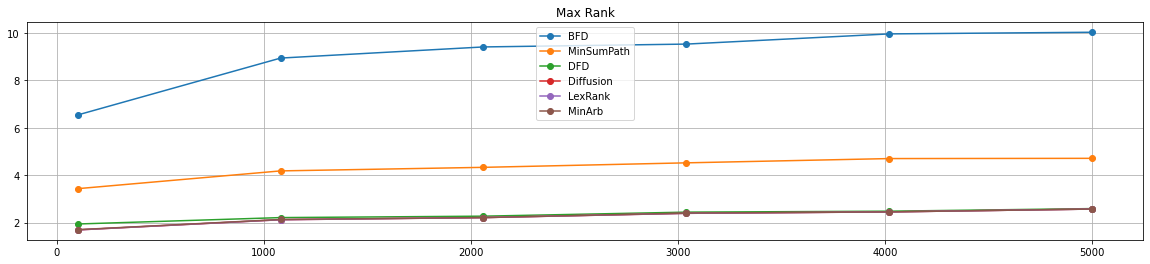

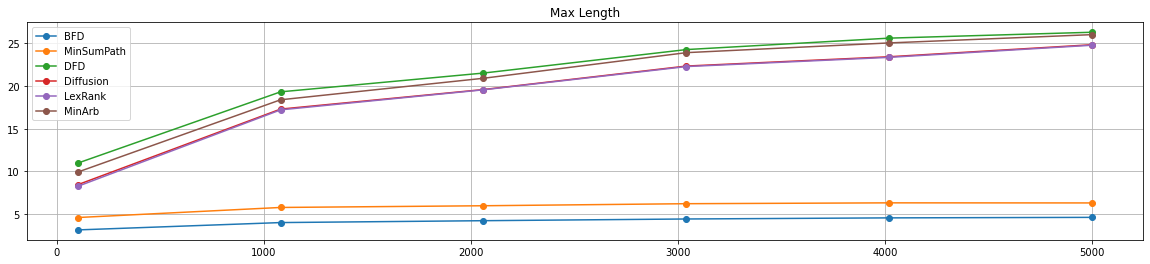

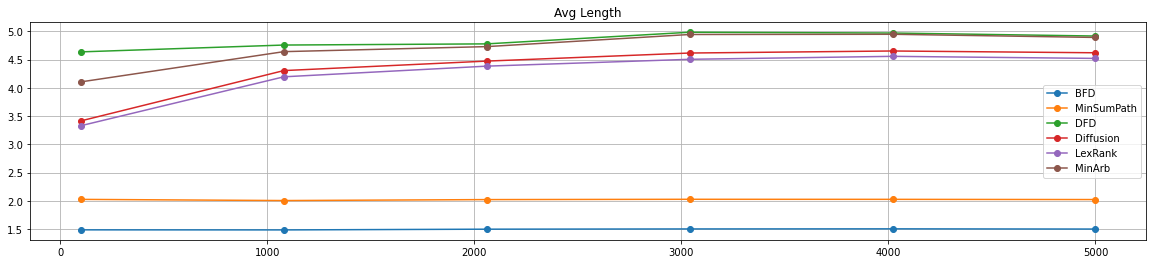

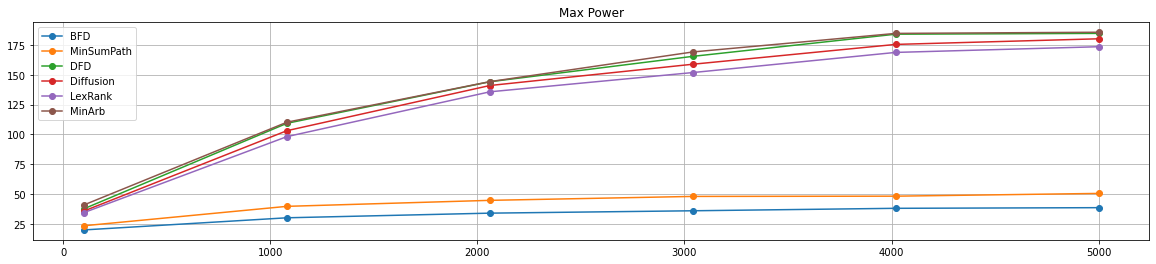

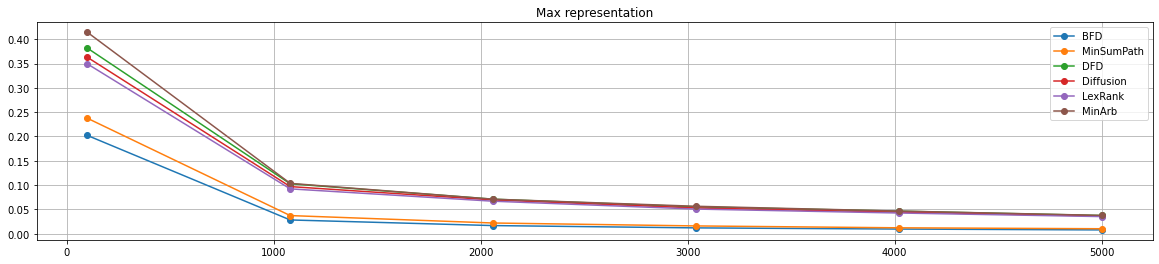

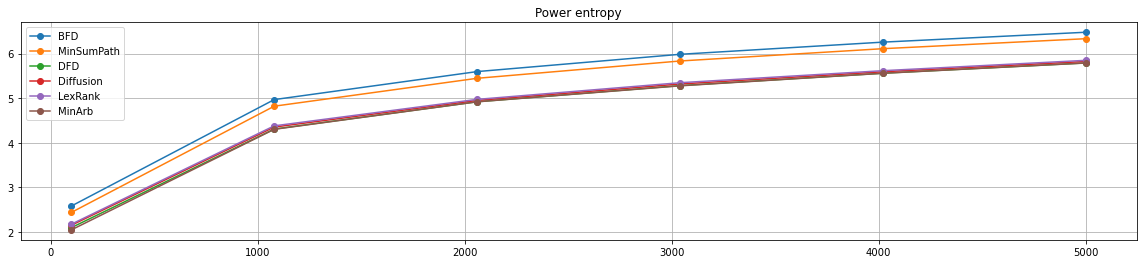

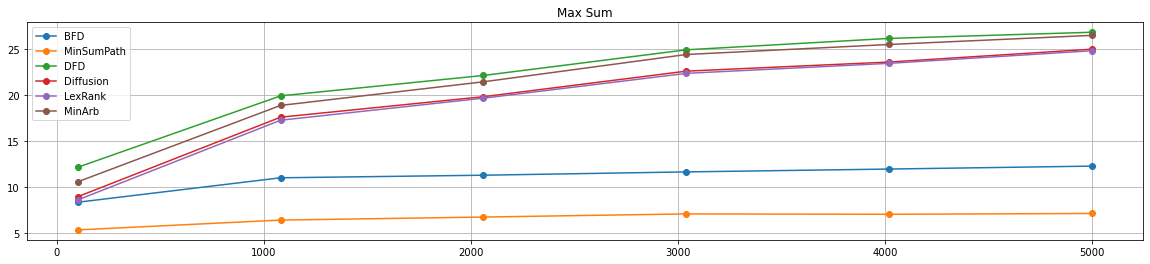

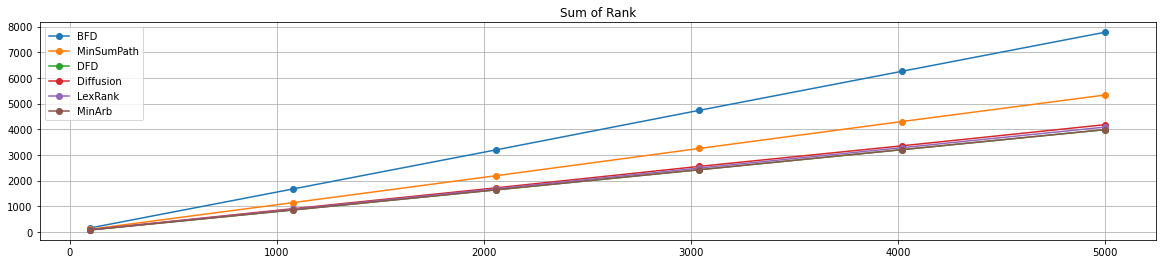

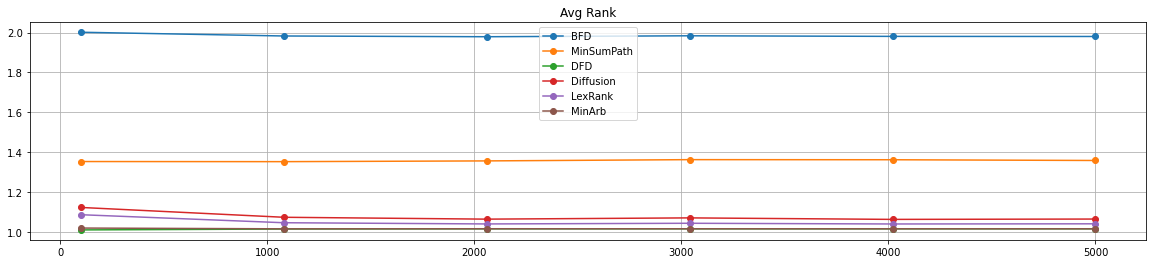

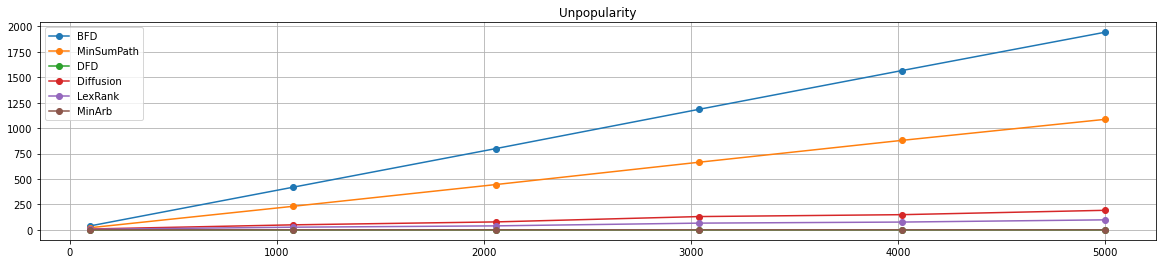

In [11]:
print_everything(evolution, "n", tab_n)

### Evolution with the proportion of delegating voters

The number of voter is $1000$, the proportion of delegating voter vary from $20\%$ to $90\%$ and the average number of delegatees per delegating voters is $4$.

In [32]:
tab_p = np.linspace(0.5,0.95,10)
evolution = []
for p in tqdm(tab_p):
    evolution.append(experiment(p=p))

100%|██████████| 10/10 [45:11<00:00, 271.13s/it]


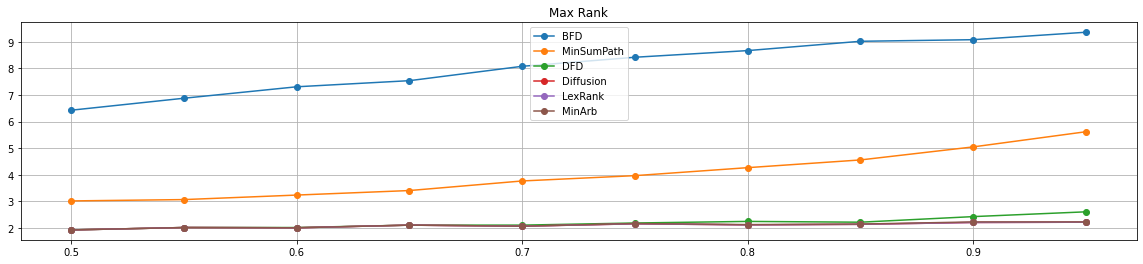

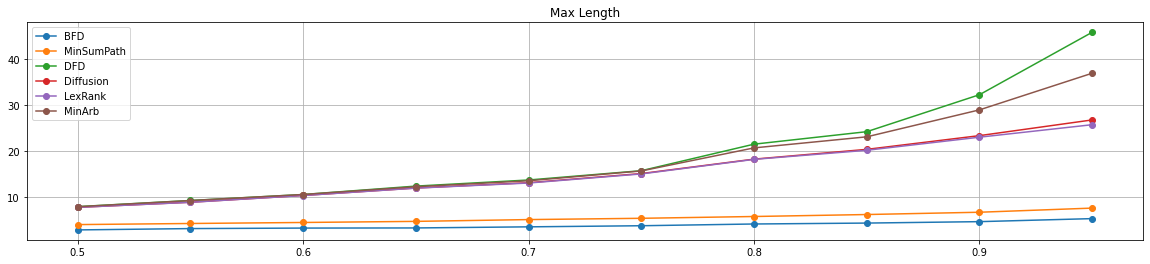

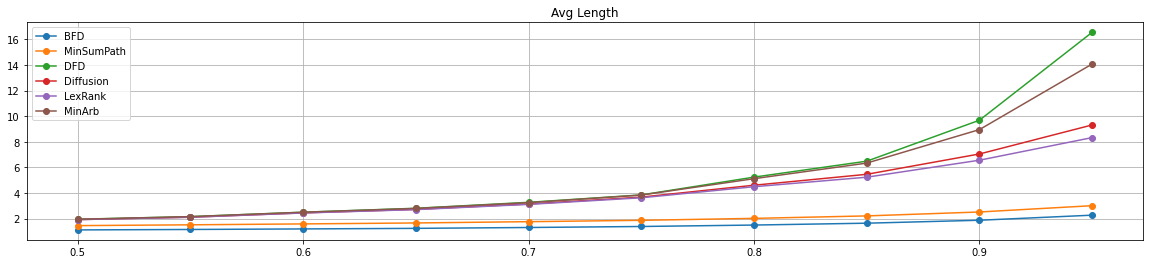

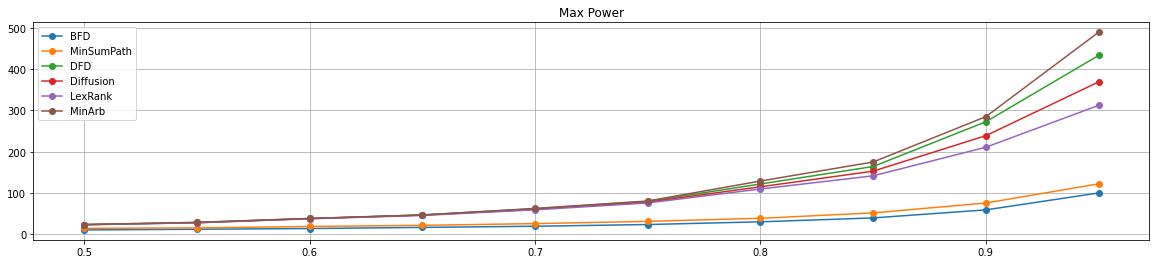

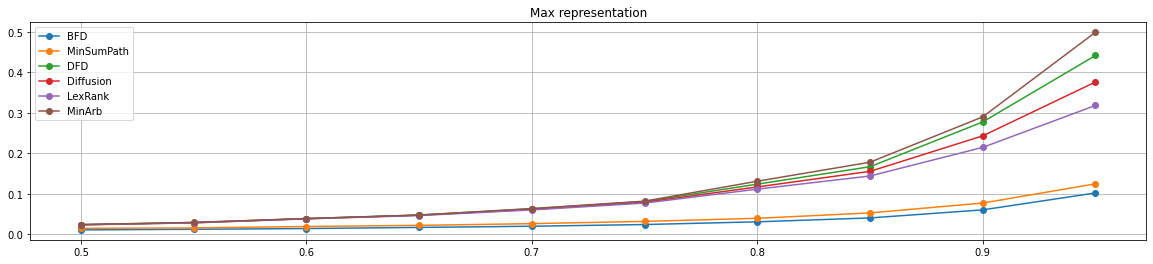

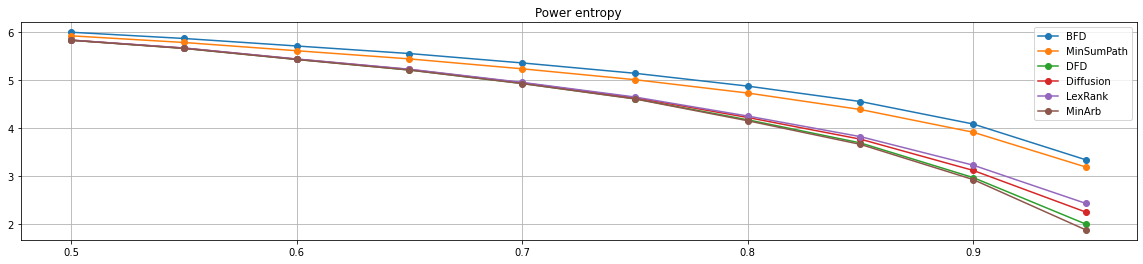

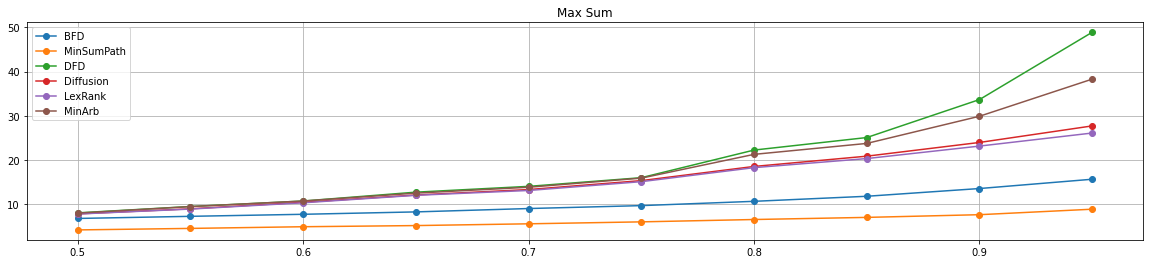

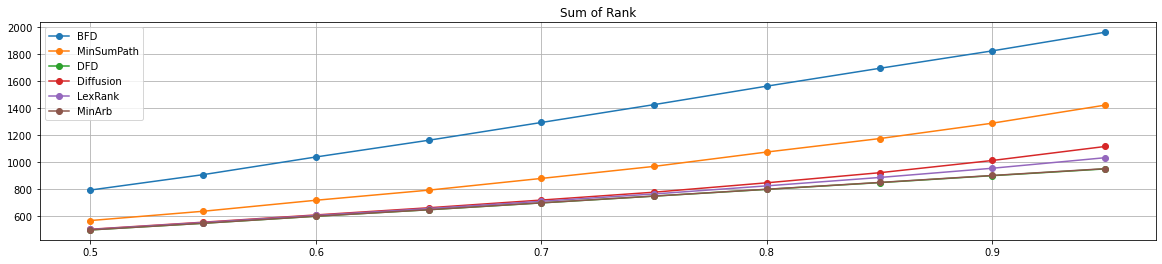

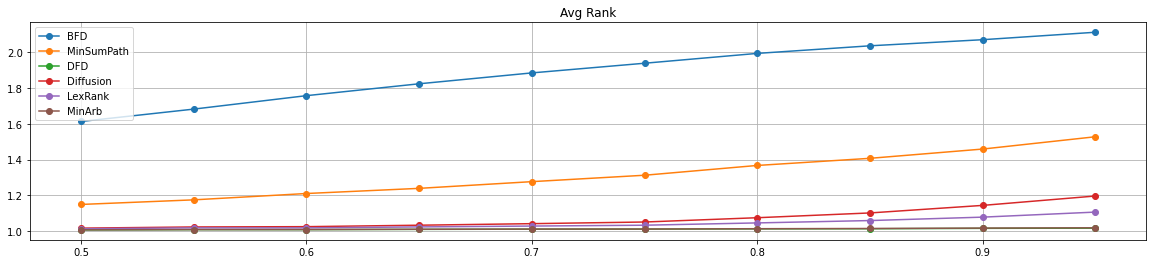

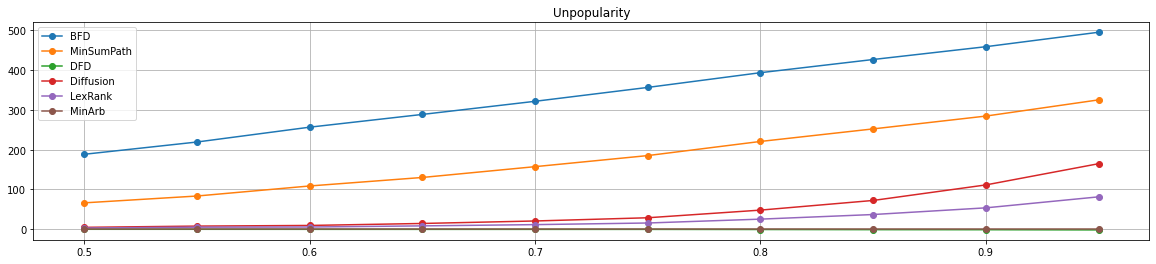

In [33]:
print_everything(evolution, "p", tab_p)

### Evolution with the average number of delegatees

The number of voters is $1000$, the proportion of delegating voters is $80\%$ and the average number of delegatees per delegating voters vary from $1$ to $8$.

In [34]:
tab_edges = np.arange(1,9)
evolution = []
for n_edges in tqdm(tab_edges):
    evolution.append(experiment(n_delegatees=n_edges))

100%|██████████| 8/8 [37:33<00:00, 281.70s/it]


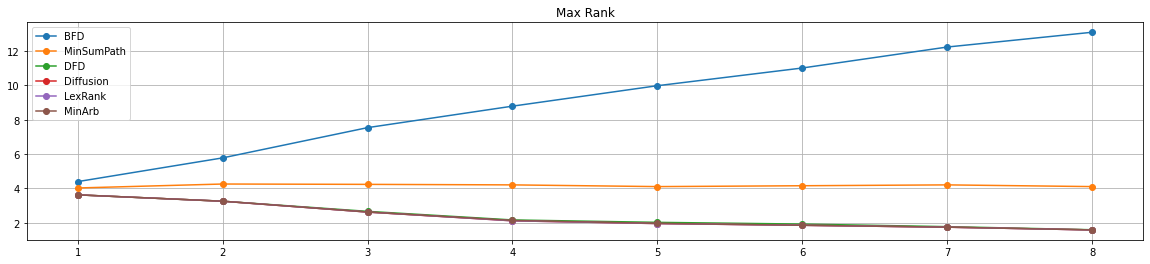

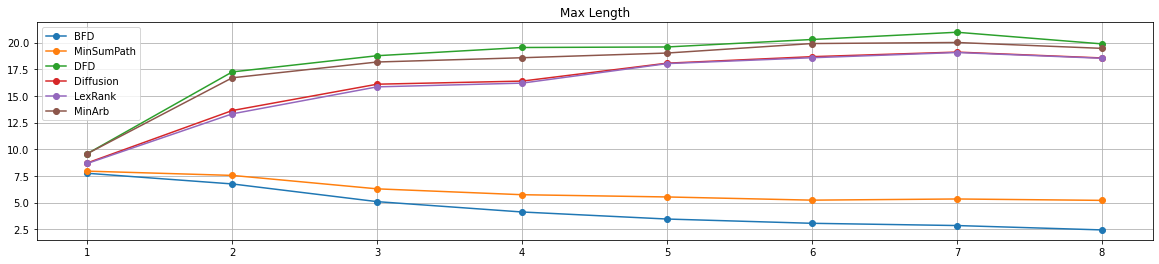

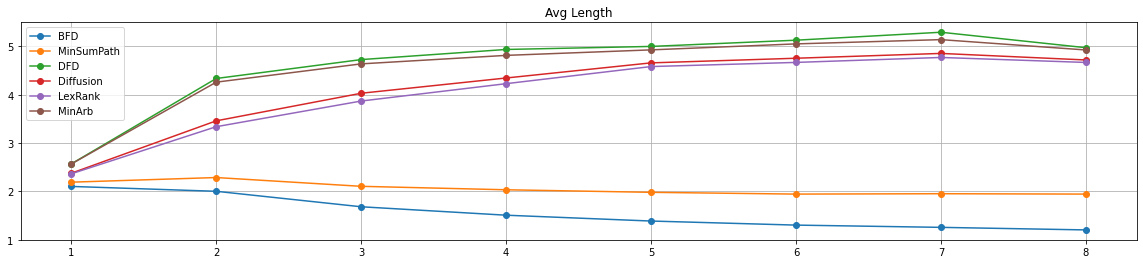

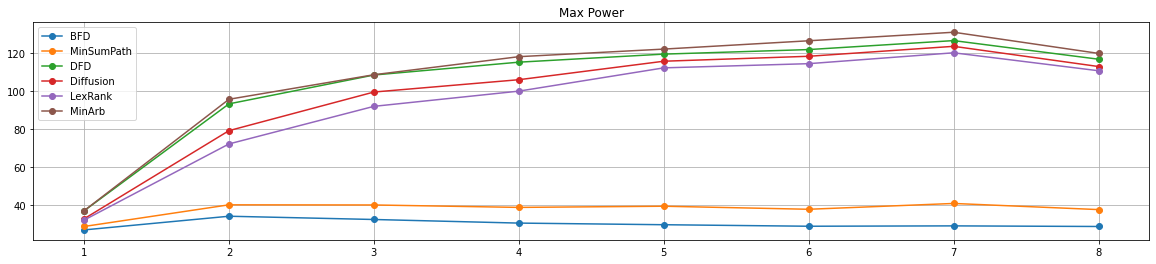

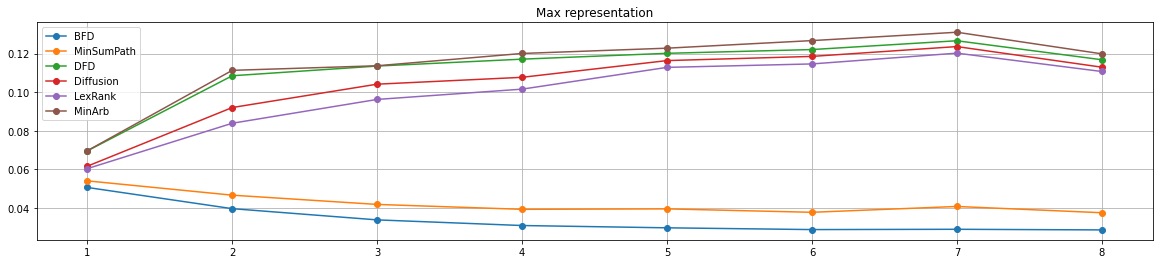

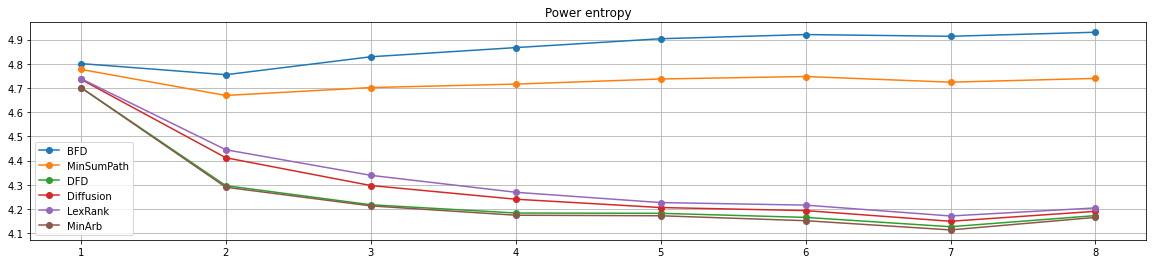

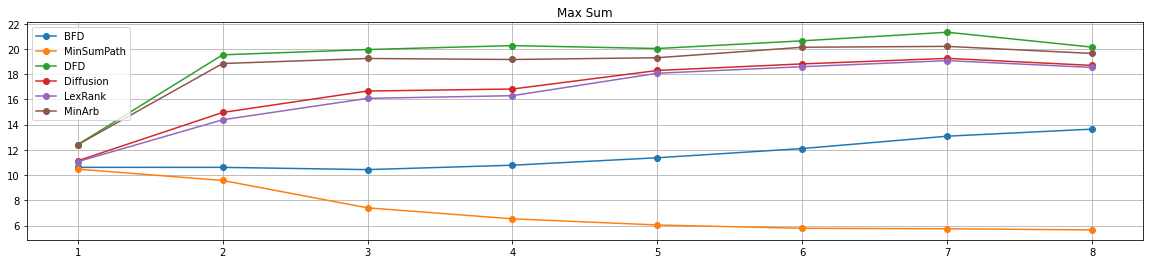

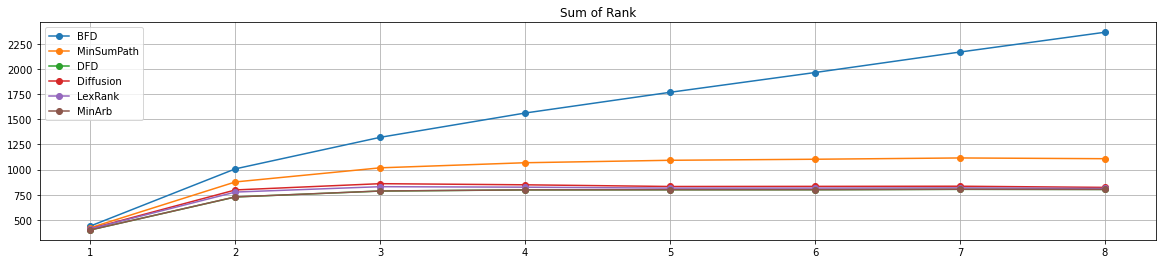

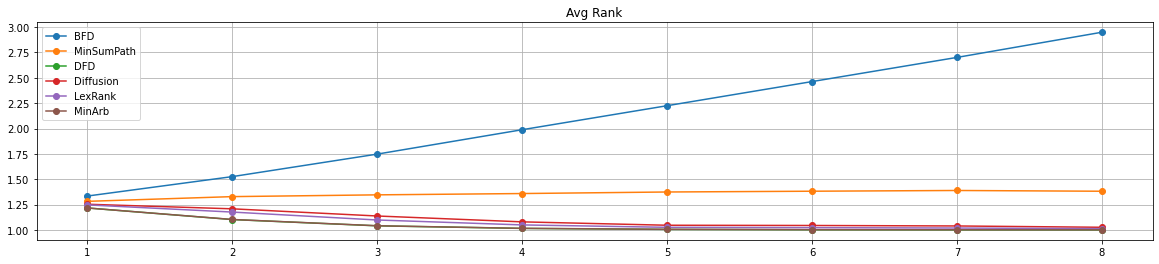

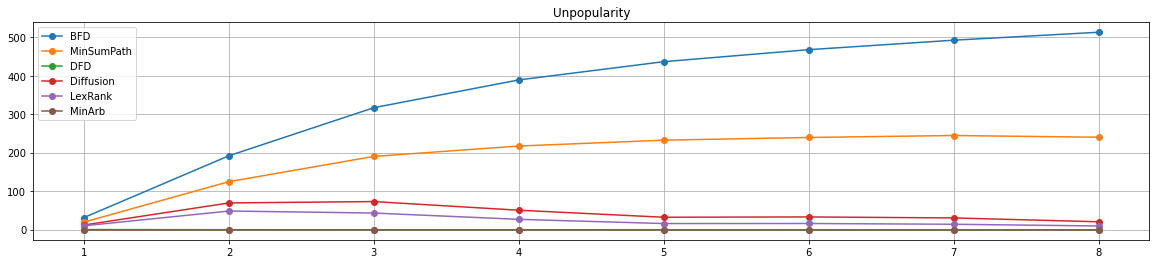

In [35]:
print_everything(evolution, "number of delegatees", tab_edges)

### Evolution with popularity factor

In [36]:
tab_pop = np.linspace(0,1,11)
evolution = []
for pop in tqdm(tab_pop):
    evolution.append(experiment(popularity=pop))

100%|██████████| 11/11 [50:02<00:00, 272.97s/it]


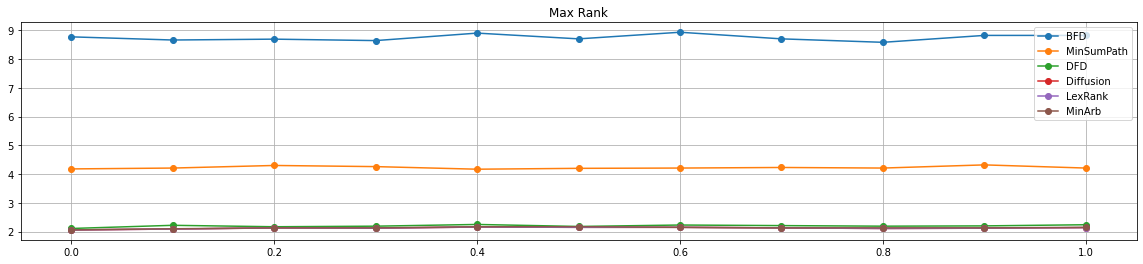

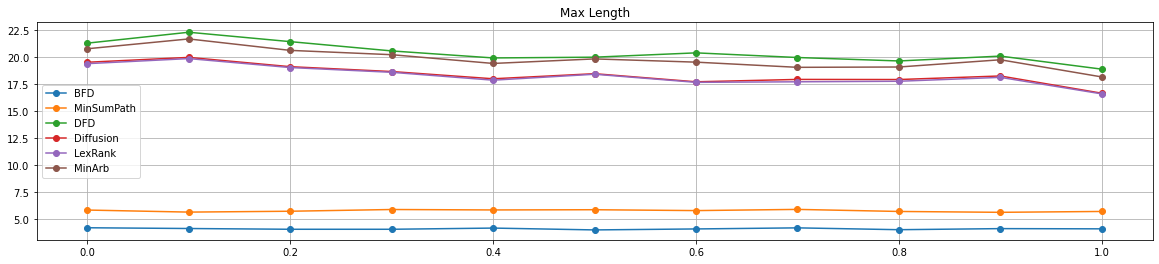

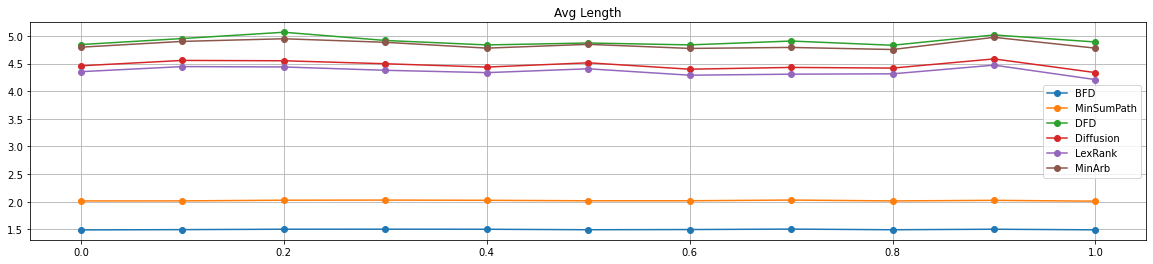

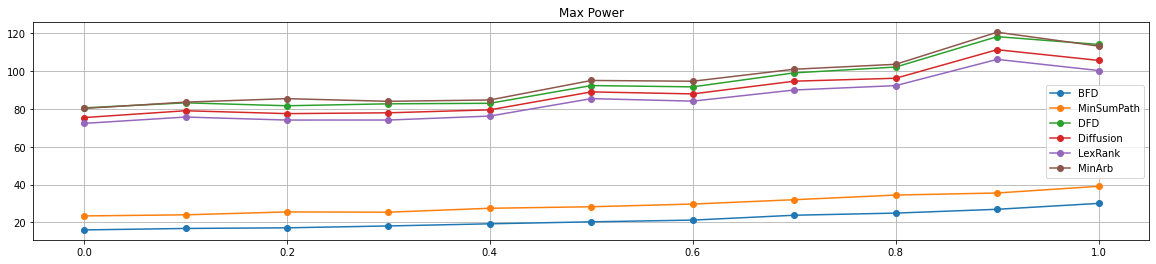

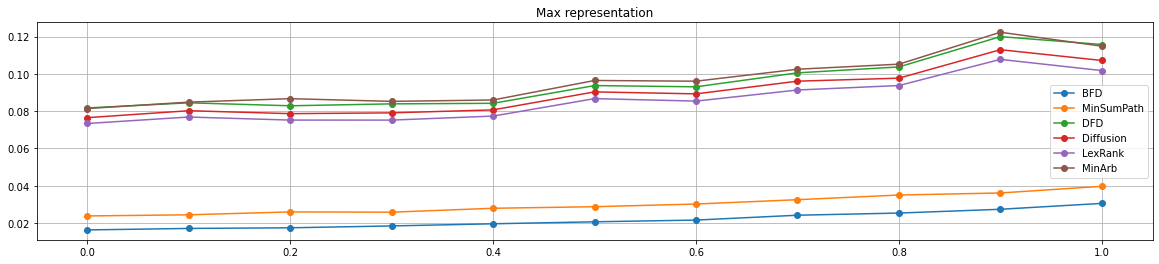

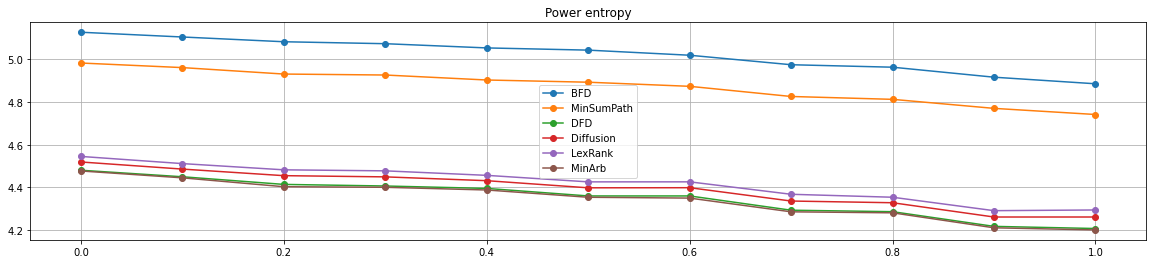

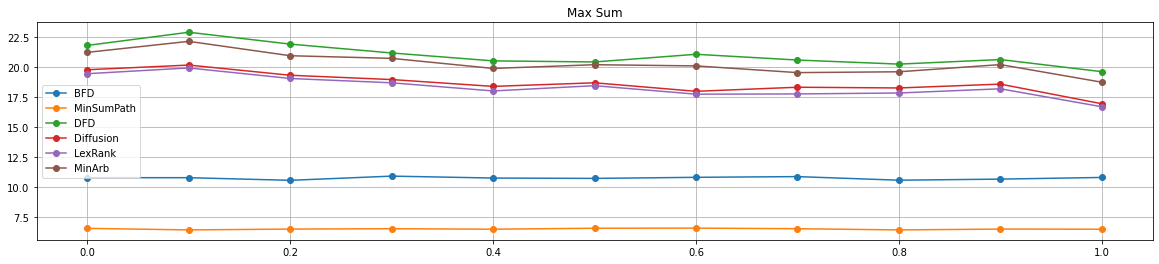

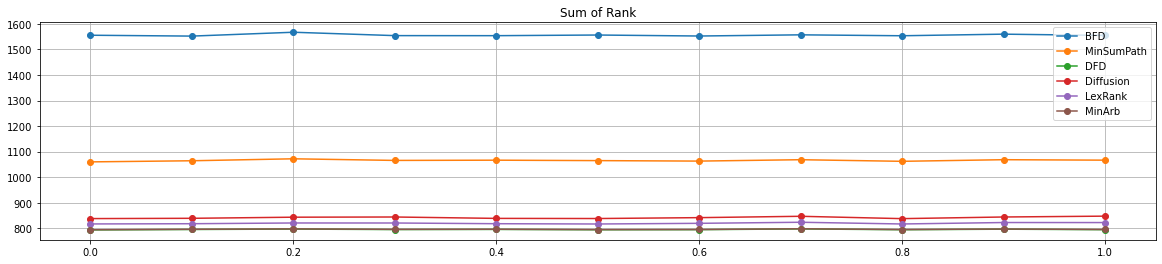

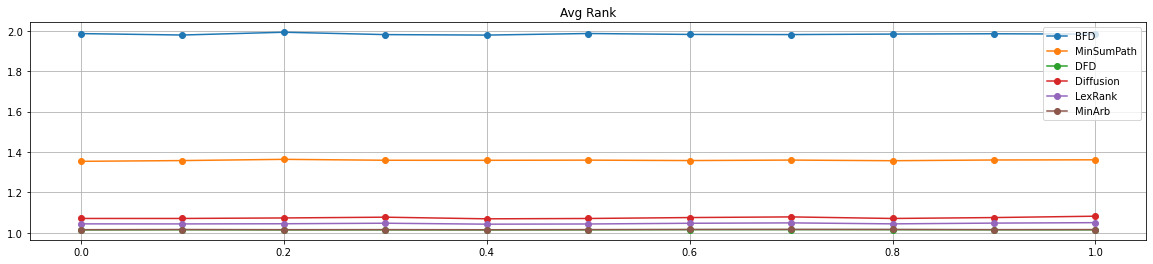

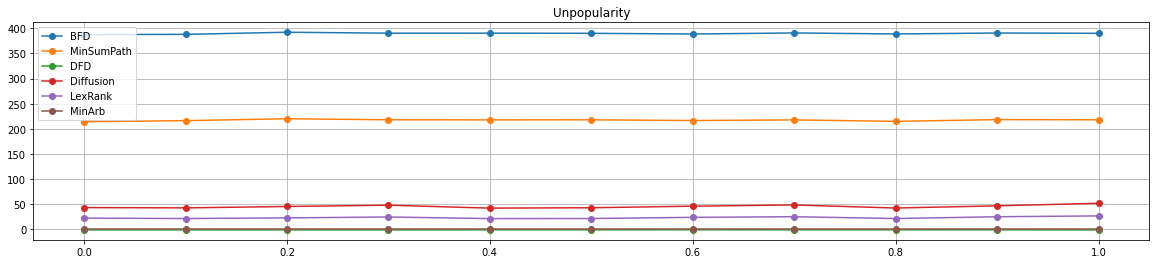

In [37]:
print_everything(evolution, "Popularity factor", tab_pop)